# 2D Phase Diagram

In [1]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import * 

<IPython.core.display.Javascript object>

## Load Json Data
* To compute the phase diagram inside the notebook is not pratical as it's very computationally expensive. The job is done in a multi-process pool routine which generates data that can be loaded and present here.

In [8]:
import sys
import os
import inspect
from os.path import join
import json
from json import dumps
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
files = []
for i in [4]: # designed to support multiple files
    files.append(f"2d_phase_map_data_0{i}.txt")
rets = []
for file in files:
    file = join(currentdir,"../",file)
    if os.path.exists(file):
        with open(file,'r') as rf:
            rets.extend(json.load(rf))
files

['2d_phase_map_data_04.txt']

### Data format
* The overall data is a list, each item in the list is a dict with 3 entries,  **mu** and **delta**($\Delta_0$), and **data**
* The format of the **data** is a list of array, each array is a tuple of 5 numbers,  corresond to: ($d\mu$, dq, g, $\Delta$, pressure). The $\Delta$ is the new value when dq and dmu are not zero, so it may be different from the $\Delta$ in the dict.



#### The piece of code in the following cell find the maximum pressure for given(mu, $\Delta_0$, dmu), which can determine if dq is zero or not

In [9]:
formattedData = []
#find the dq with maximum pressure
for items in rets:
    mu = items['mu']
    delta = items['delta']
    data = items['data']
    if len(data) > 0:
        ret = data[0]
        dmu,dq, g, d, p = ret
        for item in data:
            if dmu == item[0]:
                if item[4] > p:
                    dq = item[1]
                    p = item[4]
            else:
                formattedData.append((mu, g, dmu, dq, delta))
                dmu, dq, g, d, p, = item
        formattedData.append((mu, g, dmu, dq, delta))

### Compute density
* Take couple of minutes to compute the density

In [10]:
from mmf_hfb import FuldeFerrelState; reload(FuldeFerrelState)
ff = FuldeFerrelState.FFState(fix_g=True,k_c=500)
data = []
for i in range(len(formattedData)):
    mu, g, dmu, dq, delta = formattedData[i]
    na, nb = ff.get_densities(mu=mu, dmu=0, delta=delta)
    data.append(formattedData[i] + (na.n, nb.n,))

### Plot the phase diagram

Text(0, 0.5, '$d\\mu/\\Delta_0$')

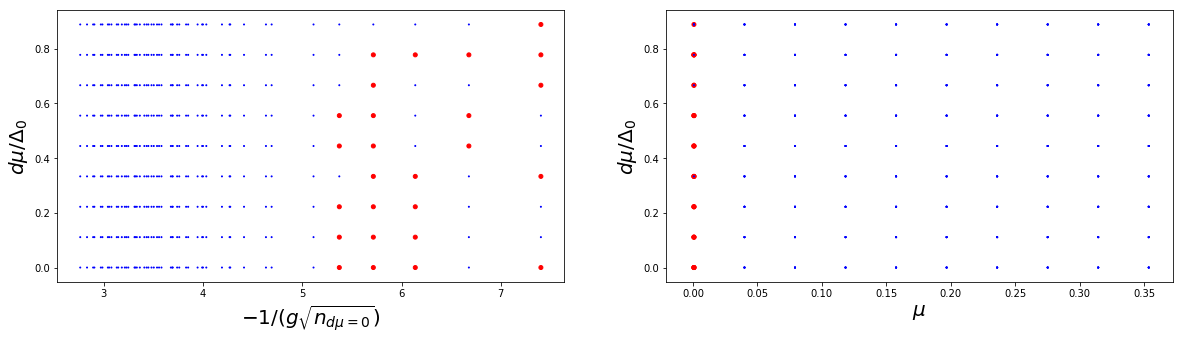

In [11]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
x,y,c,area =[],[],[],[]
for item in data:
    n = item[5] + item[6]
    x.append(-1.0/(item[1] * np.sqrt(n)))
    y.append(item[2]/item[4])
    if item[3] > 0:
        c.append('r')
        area.append(16)
    else:
        c.append('b')
        area.append(1)
plt.scatter(x, y, s=area, c=c)
plt.xlabel(r"$-1/(g\sqrt{n_{d\mu=0}})$", fontsize=20)
plt.ylabel(r"$d\mu/\Delta_0$", fontsize=20)
plt.subplot(122)
x,y=[],[]
for item in data:
    x.append(item[4])
    y.append(item[2]/item[4])

plt.scatter(x, y, s=area, c=c)
plt.xlabel(r"$\mu$", fontsize=20)
plt.ylabel(r"$d\mu/\Delta_0$", fontsize=20)